# Batch Normalization

In [1]:
import tensorflow as tf
from tensorflow import keras

from d2l.tensorflow import config, data, plot

config.setup('GPU')

Tensorflow running on GPU


In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, inference=False):
    # determine whether the current mode is training mode or prediction mode.
    if inference:
        # use the moving average
        X_hat = (X - moving_mean) / tf.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:  # fully connected layer
            mean = tf.reduce_mean(X, axis=0)
            var = tf.reduce_mean((X - mean) ** 2, axis=0)
        else:  # convolution, hence per layer
            mean = tf.reduce_mean(X, axis=(0, 2, 3), keepdims=True)
            var = tf.reduce_mean((X - mean) ** 2, axis=(0, 2, 3), keepdims=True)
            # In training mode, the current mean and variance
            # are used for the standardization.
            X_hat = (X - mean) / tf.sqrt(var + eps)
            # Update the mean and variance of the moving average.
            moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
            moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift.
    return Y, moving_mean, moving_var

## LeNet with Batch Normalization

In [3]:
lenet = keras.models.Sequential()

lenet.add(keras.layers.Conv2D(filters=6, kernel_size=5, input_shape=(28, 28, 1), padding='same'))
lenet.add(keras.layers.BatchNormalization())
lenet.add(keras.layers.Activation('sigmoid'))
lenet.add(keras.layers.AveragePooling2D(pool_size=2, strides=2))

lenet.add(keras.layers.Conv2D(filters=16, kernel_size=5, padding='same'))
lenet.add(keras.layers.BatchNormalization())
lenet.add(keras.layers.Activation('sigmoid'))
lenet.add(keras.layers.AveragePooling2D(pool_size=2, strides=2))

lenet.add(keras.layers.Flatten())

lenet.add(keras.layers.Dense(units=120))
lenet.add(keras.layers.BatchNormalization())
lenet.add(keras.layers.Activation('sigmoid'))
lenet.add(keras.layers.Dense(units=84))
lenet.add(keras.layers.BatchNormalization())
lenet.add(keras.layers.Activation('sigmoid'))
lenet.add(keras.layers.Dense(units=10, activation='softmax'))

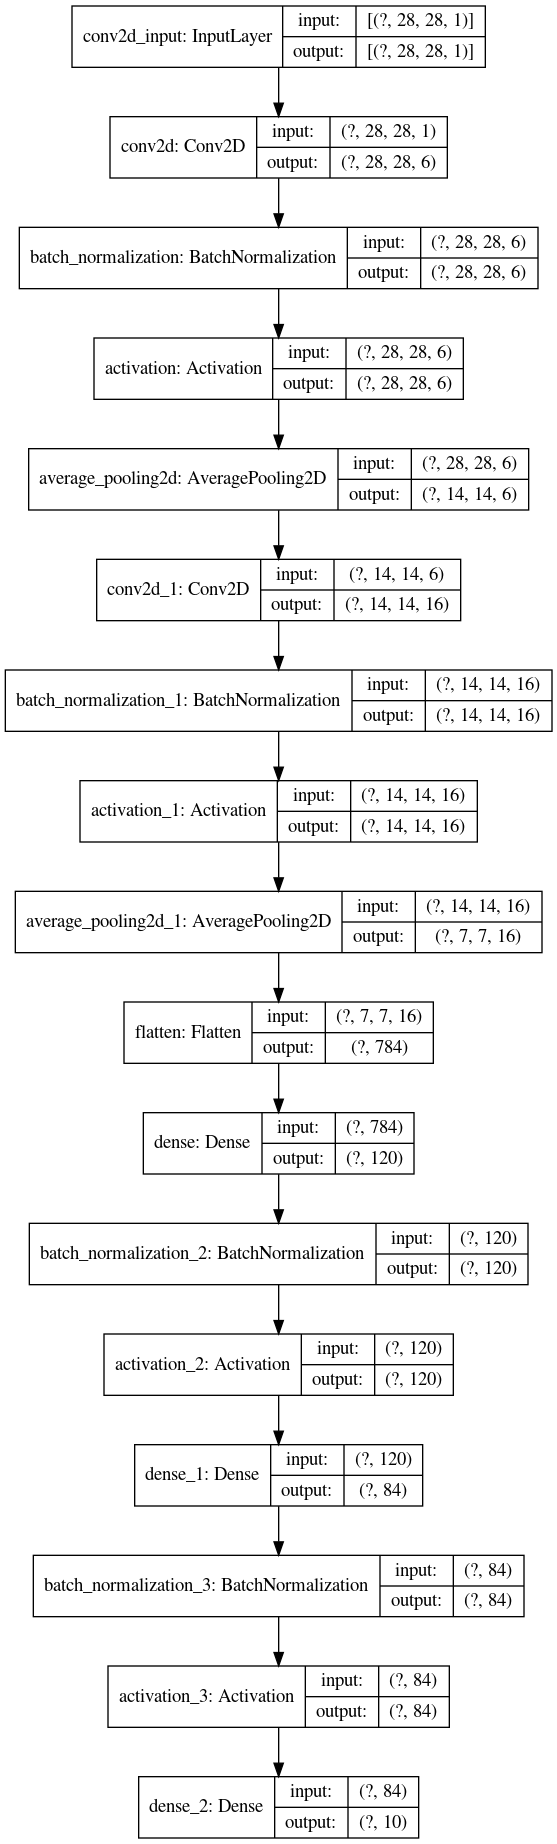

In [4]:
keras.utils.plot_model(lenet, show_shapes=True, to_file='lenet_batch_norm.png')

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [6]:
batch_size = 256
epochs = 20
learning_rate = 0.3

optmizer = keras.optimizers.SGD(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()
metric = keras.metrics.CategoricalAccuracy()

lenet.compile(optimizer=optmizer, loss=loss, metrics=metric)

In [7]:
hist = lenet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
235/235 [==============================] - 14s 59ms/step - loss: 0.6863 - categorical_accuracy: 0.7872 - val_loss: 1.3807 - val_categorical_accuracy: 0.6690
Epoch 2/20
235/235 [==============================] - 13s 54ms/step - loss: 0.4440 - categorical_accuracy: 0.8466 - val_loss: 0.6622 - val_categorical_accuracy: 0.7679
Epoch 3/20
235/235 [==============================] - 12s 50ms/step - loss: 0.3849 - categorical_accuracy: 0.8638 - val_loss: 0.5374 - val_categorical_accuracy: 0.8026
Epoch 4/20
235/235 [==============================] - 12s 50ms/step - loss: 0.3469 - categorical_accuracy: 0.8767 - val_loss: 0.4145 - val_categorical_accuracy: 0.8516
Epoch 5/20
235/235 [==============================] - 12s 50ms/step - loss: 0.3172 - categorical_accuracy: 0.8856 - val_loss: 0.4625 - val_categorical_accuracy: 0.8308
Epoch 6/20
235/235 [==============================] - 12s 49ms/step - loss: 0.2982 - categorical_accuracy: 0.8930 - val_loss: 0.3689 - val_categorical_accuracy:

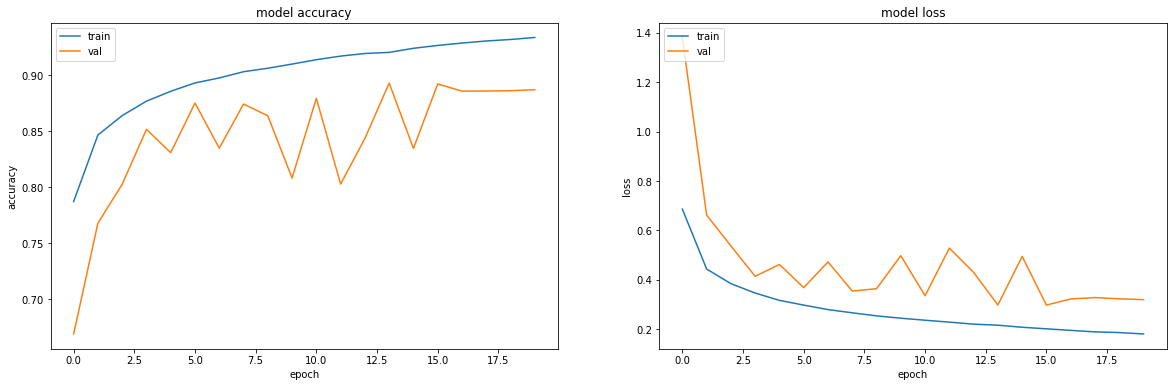

In [8]:
plot.plot_history(hist, 'categorical_accuracy')